In [135]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [136]:
import tensorflow as tf

In [159]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 30
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0

In [160]:
def visualize_data(images, categories, class_names):
    fig = plt.figure(figsize=(14, 6))
    fig.patch.set_facecolor('white')
    for i in range(3 * 7):
        plt.subplot(3, 7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        class_index = categories[i].argmax()
        plt.xlabel(class_names[class_index])
    plt.show()

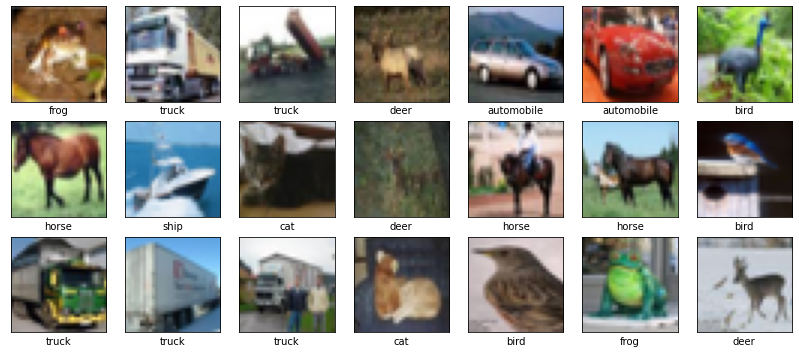

In [161]:
# Load CIFAR10 Data

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

X_train = X_train / 255.0
y_train = to_categorical(y_train, num_classes)

X_test = X_test / 255.0
y_test = to_categorical(y_test, num_classes)

visualize_data(X_train, y_train, class_names)

In [162]:
X_train.shape

(50000, 32, 32, 3)

In [163]:
X_test.shape

(10000, 32, 32, 3)

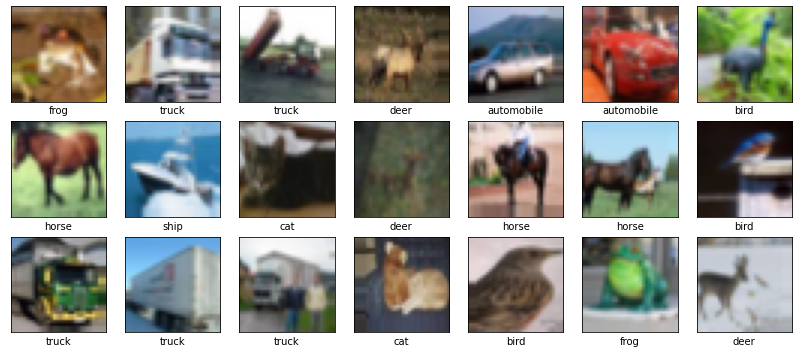

In [164]:
width_shift = 3/32
height_shift = 3/32
flip = True

datagen = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift,
    )
datagen.fit(X_train)

it = datagen.flow(X_train, y_train, shuffle=False)
batch_images, batch_labels = next(it)
visualize_data(batch_images, batch_labels, class_names)

In [165]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Block
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [166]:

l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

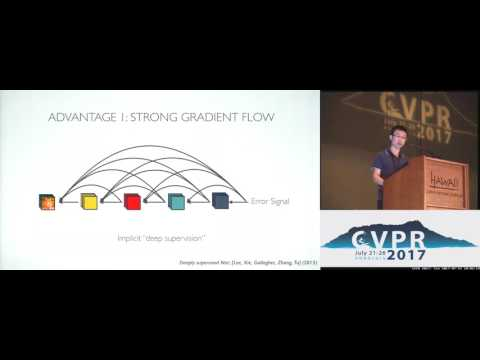

In [167]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [168]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_520 (Conv2D)             (None, 32, 32, 12)   324         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_520 (BatchN (None, 32, 32, 12)   48          conv2d_520[0][0]                 
__________________________________________________________________________________________________
activation_520 (Activation)     (None, 32, 32, 12)   0           batch_normalization_520[0][0]    
______________________________________________________________________________________

In [169]:
print(len(model.layers))

211


In [170]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [171]:
model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(X_test, y_test))

Epoch 1/30
391/391 [==============================] - 1781s 5s/step - loss: 1.5756 - accuracy: 0.4203 - val_loss: 1.5760 - val_accuracy: 0.4217
Epoch 2/30
391/391 [==============================] - 1779s 5s/step - loss: 1.2126 - accuracy: 0.5605 - val_loss: 1.4127 - val_accuracy: 0.4988
Epoch 3/30
391/391 [==============================] - 1556s 4s/step - loss: 1.0429 - accuracy: 0.6243 - val_loss: 1.2281 - val_accuracy: 0.5707
Epoch 4/30
391/391 [==============================] - 1557s 4s/step - loss: 0.9339 - accuracy: 0.6673 - val_loss: 1.0738 - val_accuracy: 0.6253
Epoch 5/30
391/391 [==============================] - 1554s 4s/step - loss: 0.8506 - accuracy: 0.6964 - val_loss: 1.1601 - val_accuracy: 0.6070
Epoch 6/30
391/391 [==============================] - 1561s 4s/step - loss: 0.7793 - accuracy: 0.7227 - val_loss: 0.9531 - val_accuracy: 0.6697
Epoch 7/30
391/391 [==============================] - 1585s 4s/step - loss: 0.7291 - accuracy: 0.7417 - val_loss: 0.8479 - val_accuracy:

In [172]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 45s 145ms/step - loss: 0.9863 - accuracy: 0.7420
Test loss: 0.9862914085388184
Test accuracy: 0.7419999837875366


In [173]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk
